# 01 Import libraries

In [2]:
import numpy as np
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")

Using device: cpu


In [3]:
import pandas as pd

In [4]:
import importlib

In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
import lib
importlib.reload(lib)

<module 'lib' from 'c:\\Users\\dongq\\OneDrive\\Desktop\\New results\\Learning-the-Optimal-Solution-Path\\lib\\__init__.py'>

In [ ]:
from lib.lsp.learn_solution_path import learn_solution_path_high_dim
from lib.fast_tensor_data_loader import FastTensorDataLoader

# 02 Instantiate dataset

In [8]:
# file path
decomp_cov_df = pd.read_csv('decomp_cov.csv')
mean_df = pd.read_csv('mean.csv')

In [9]:
decomp_cov_np = np.array(decomp_cov_df)
mean_np = np.array(mean_df).squeeze()

In [10]:
decomp_cov = torch.tensor(decomp_cov_np, dtype=torch.float32)
mean = torch.tensor(mean_np, dtype=torch.float32)

In [11]:
decomp_cov

tensor([[ 3.8584,  4.6557,  4.0503,  4.7056,  3.3298,  3.4872,  3.2121,  2.7176,
          2.7919,  3.9016],
        [ 0.0000,  9.6246,  1.4167,  1.5061,  2.6207,  0.6535,  2.1278,  0.8926,
         -0.1126,  1.8297],
        [ 0.0000,  0.0000,  2.6853,  2.6613,  1.4872,  1.3278,  1.2272,  1.4394,
          0.4031,  2.2804],
        [ 0.0000,  0.0000,  0.0000,  6.7527, -0.6083,  0.5163, -0.4300, -0.2296,
         -0.1087,  0.6784],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  3.0578,  0.4449,  1.4199,  0.8157,
          0.1635,  0.2507],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.9848,  0.2056,  0.2594,
         -0.0997,  0.5166],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.2011,  0.7656,
          0.1802,  0.1505],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.6989,
         -0.2101,  0.1462],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          3.0994, -0.2774],
        [ 0.0000,  

In [12]:
# full gradient descent uses all data points
GD_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )
# test data
test_data_loader = FastTensorDataLoader(decomp_cov, mean, batch_size=len(decomp_cov), shuffle=False, )

In [13]:
dim_lambda = 12
lam_max_high_dim = np.ones(dim_lambda)
lam_min_high_dim = np.zeros(dim_lambda)
lam_min_high_dim[2:] = -2
lam_min_high_dim[0] = .2
lam_max_high_dim[2:] = 2
input_dim = decomp_cov.shape[1]

In [14]:
lam_min_high_dim

array([ 0.2,  0. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. , -2. ,
       -2. ])

In [15]:
lam_max_high_dim

array([1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

# 03 Define the Basis Generator

In [250]:
def taylor(lam, k):
    taylor_terms = np.append(np.ones(1), lam)
    for i in range(k):
        taylor_terms = np.append(taylor_terms, lam * (lam[0]**(i+1)))
    return taylor_terms

In [132]:
test = taylor(lam_min_high_dim, 3)
test

array([ 2.0e-01,  0.0e+00, -2.0e+00, -2.0e+00, -2.0e+00, -2.0e+00,
       -2.0e+00, -2.0e+00, -2.0e+00, -2.0e+00, -2.0e+00, -2.0e+00,
        4.0e-02,  0.0e+00, -4.0e-01, -4.0e-01, -4.0e-01, -4.0e-01,
       -4.0e-01, -4.0e-01, -4.0e-01, -4.0e-01, -4.0e-01, -4.0e-01,
        8.0e-03,  0.0e+00, -8.0e-02, -8.0e-02, -8.0e-02, -8.0e-02,
       -8.0e-02, -8.0e-02, -8.0e-02, -8.0e-02, -8.0e-02, -8.0e-02,
        1.6e-03,  0.0e+00, -1.6e-02, -1.6e-02, -1.6e-02, -1.6e-02,
       -1.6e-02, -1.6e-02, -1.6e-02, -1.6e-02, -1.6e-02, -1.6e-02])

# 04 Define the Loss Function

In [36]:
from numpy.linalg import inv

when lam_1/lam_2 = 1

In [38]:
inv(decomp_cov_np) @ mean_np /2 *5

array([-1.64057426, -0.05696513, -1.95674072,  0.26509981,  0.52782249,
       -0.02529369,  0.97657385,  0.82896155,  0.73344576,  1.50473187])

In [37]:
alpha = .1

In [ ]:
# balance expected return, risk, and diversification
# constraint is that sum of model weight should be 1. We achieve this by setting the first term of weight
# to equal (1- sum of remaining terms of weight)
def allocation_cost_train(hyper_params, decomp_cov, mean, model, device="cpu"):
    # compute predicted y_hat
    n = decomp_cov.shape[1]
    # no need to transform lambdas
    theta = model(hyper_params, device)
    risk = torch.mm(decomp_cov, theta.view(-1, 1))
    exp_rtrn = torch.mm(mean.view(-1, 1).T, theta.view(-1, 1))
    cost = (theta - torch.tensor(hyper_params[2:], dtype=torch.float32)).norm(p=2)**2

    # input hyperparameter lam is a 2-d array
    loss = hyper_params[0] * risk.norm(p=2)**2 - hyper_params[1] * exp_rtrn + cost + alpha * ((model.linear.weight[1:, :]).norm(p=2)**2)


    return loss

In [ ]:
# balance expected return, risk, and diversification
# constraint is that sum of model weight should be 1. We achieve this by setting the first term of weight
# to equal (1- sum of remaining terms of weight)
def allocation_cost_val(hyper_params, decomp_cov, mean, model, device="cpu"):
    # compute predicted y_hat
    n = decomp_cov.shape[1]
    # no need to transform lambdas
    theta = model(hyper_params, device)
    risk = torch.mm(decomp_cov, theta.view(-1, 1))
    exp_rtrn = torch.mm(mean.view(-1, 1).T, theta.view(-1, 1))
    cost = (theta - torch.tensor(hyper_params[2:], dtype=torch.float32)).norm(p=2)**2

    # input hyperparameter lam is a 2-d array
    loss = hyper_params[0] * risk.norm(p=2)**2 - hyper_params[1] * exp_rtrn + cost



    return loss

In [133]:
loss_fn_train = allocation_cost_val
loss_fn_val = allocation_cost_val

# 03 Exact Gradient with Diminishing LR by Distance Diagnostic

We use diminishing learning rate for better demonstrate convergence. If we use a constant learning rate, the solution path error will eventually do a random walk after descending to a certain threshold value.

Set weighted_avg to 'False' see this random walk.

In [41]:
def thresh_basis(basis_dim):
    return -1

In [ ]:
np.random.seed(42)
train_set = []
for j in range(1000):
    samples = uniform.rvs(loc=0, scale=1, size=len(lam_min_high_dim))
    train_set.append(samples * (lam_max_high_dim - lam_min_high_dim) + lam_min_high_dim)

In [90]:
train_set[0]

array([ 0.4996321 ,  0.95071431,  0.92797577,  0.39463394, -1.37592544,
       -1.37602192, -1.76766555,  1.46470458,  0.40446005,  0.83229031,
       -1.91766202,  1.87963941])

In [91]:
np.random.seed(88)
val_set = []
for j in range(1000):
    samples = uniform.rvs(loc=0, scale=1, size=len(lam_min_high_dim))
    val_set.append(samples * (lam_max_high_dim - lam_min_high_dim) + lam_min_high_dim)

In [258]:
val_losses = []

In [259]:
train_losses = []

In [260]:
train_losses_reg = []

In [156]:
p = 4
# p = basis_dim

In [157]:
obj = RF_Map(dim_lambda, p)

## k = 0

In [261]:
k = 0

In [262]:
basis_dim = (k+1) * len(lam_min_high_dim)+1
init_lr = .1

In [263]:
basis_dim

13

In [ ]:
def taylor_expansion(lam, basis_dim, device='cpu'):
    vec = torch.tensor(taylor(lam, k), dtype=torch.float32)
    return vec.to(device)

In [ ]:
phi_lam = taylor_expansion

In [268]:
max_epochs = 15

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

loss_train, loss_val, loss_train_reg, weight = learn_solution_path_high_dim(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn_train, loss_fn_val,
                                                               lam_min_high_dim, lam_max_high_dim, init_lr=init_lr,
                                                               diminish=False, 
                                                               intercept=False, weighted_avg=False, thresh_basis=thresh_basis,
                                                            #    record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=-1, distribution='uniform',
                                                               opt_method='lbfgs',
                                                               device=device, trace_frequency=1)

--------approximate solution path for # function evaluation = 0 complete--------
# gradient call: 0	 average loss on training: 13.347564279019833
# gradient call: 0	 average loss on validation: 13.228360370635986
--------approximate solution path for # function evaluation = 20 complete--------
# gradient call: 1	 average loss on training: 10.80931499683857
# gradient call: 1	 average loss on validation: 10.736429775595665
--------approximate solution path for # function evaluation = 40 complete--------
# gradient call: 2	 average loss on training: 10.750468260645867
# gradient call: 2	 average loss on validation: 10.681588576316834
--------approximate solution path for # function evaluation = 60 complete--------
# gradient call: 3	 average loss on training: 10.748742209136486
# gradient call: 3	 average loss on validation: 10.680705457568168
--------approximate solution path for # function evaluation = 80 complete--------
# gradient call: 4	 average loss on training: 10.748371291041375

In [270]:
val_losses.append(loss_val)
train_losses.append(loss_train)
train_losses_reg.append(loss_train_reg)

## k = 1

In [271]:
k = 1

In [272]:
basis_dim = (k+1) * len(lam_min_high_dim)+1
init_lr = .1

In [273]:
basis_dim

25

In [ ]:
def taylor_expansion(lam, basis_dim, device='cpu'):
    vec = torch.tensor(taylor(lam, k), dtype=torch.float32)
    return vec.to(device)

In [ ]:
phi_lam = taylor_expansion

In [276]:
max_epochs = 15

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

loss_train, loss_val, loss_train_reg, weight = learn_solution_path_high_dim(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn_train, loss_fn_val,
                                                               lam_min_high_dim, lam_max_high_dim, init_lr=init_lr,
                                                               diminish=False, 
                                                               intercept=False, weighted_avg=False, thresh_basis=thresh_basis,
                                                            #    record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=-1, distribution='uniform',
                                                               opt_method='lbfgs',
                                                               device=device, trace_frequency=1)

--------approximate solution path for # function evaluation = 0 complete--------
# gradient call: 0	 average loss on training: 13.347564279019833
# gradient call: 0	 average loss on validation: 13.228360370635986
--------approximate solution path for # function evaluation = 20 complete--------
# gradient call: 1	 average loss on training: 10.916346399188042
# gradient call: 1	 average loss on validation: 10.841226837873458
--------approximate solution path for # function evaluation = 40 complete--------
# gradient call: 2	 average loss on training: 10.774703300058842
# gradient call: 2	 average loss on validation: 10.708461448788643
--------approximate solution path for # function evaluation = 60 complete--------
# gradient call: 3	 average loss on training: 10.59899225270748
# gradient call: 3	 average loss on validation: 10.531228645443916
--------approximate solution path for # function evaluation = 80 complete--------
# gradient call: 4	 average loss on training: 10.562965951502322

In [278]:
val_losses.append(loss_val)
train_losses.append(loss_train)
train_losses_reg.append(loss_train_reg)

## k = 2

In [279]:
k = 2

In [280]:
basis_dim = (k+1) * len(lam_min_high_dim)+1
init_lr = .1

In [281]:
basis_dim

37

In [ ]:
def taylor_expansion(lam, basis_dim, device='cpu'):
    vec = torch.tensor(taylor(lam, k), dtype=torch.float32)
    return vec.to(device)

In [ ]:
phi_lam = taylor_expansion

In [284]:
max_epochs = 15

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

loss_train, loss_val, loss_train_reg, weight = learn_solution_path_high_dim(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn_train, loss_fn_val,
                                                               lam_min_high_dim, lam_max_high_dim, init_lr=init_lr,
                                                               diminish=False, 
                                                               intercept=False, weighted_avg=False, thresh_basis=thresh_basis,
                                                            #    record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=-1, distribution='uniform',
                                                               opt_method='lbfgs',
                                                               device=device, trace_frequency=1)

--------approximate solution path for # function evaluation = 0 complete--------
# gradient call: 0	 average loss on training: 13.347564279019833
# gradient call: 0	 average loss on validation: 13.228360370635986
--------approximate solution path for # function evaluation = 20 complete--------
# gradient call: 1	 average loss on training: 10.980198944687844
# gradient call: 1	 average loss on validation: 10.90364107310772
--------approximate solution path for # function evaluation = 40 complete--------
# gradient call: 2	 average loss on training: 10.743169210791589
# gradient call: 2	 average loss on validation: 10.67783568251133
--------approximate solution path for # function evaluation = 60 complete--------
# gradient call: 3	 average loss on training: 10.587154631078244
# gradient call: 3	 average loss on validation: 10.518537198662758
--------approximate solution path for # function evaluation = 80 complete--------
# gradient call: 4	 average loss on training: 10.565372721910476


In [286]:
val_losses.append(loss_val)
train_losses.append(loss_train)
train_losses_reg.append(loss_train_reg)

## k = 3

In [251]:
k = 3

In [252]:
basis_dim = (k+1) * len(lam_min_high_dim) +1
init_lr = .1

In [253]:
basis_dim

49

In [ ]:
def taylor_expansion(lam, basis_dim, device='cpu'):
    vec = torch.tensor(taylor(lam, k), dtype=torch.float32)
    return vec.to(device)

In [ ]:
phi_lam = taylor_expansion

In [256]:
max_epochs = 10

In [ ]:
np.random.seed(8675309)
torch.manual_seed(8675309)

loss_train, loss_val, loss_train_reg, weight = learn_solution_path_high_dim(input_dim, basis_dim, phi_lam, max_epochs,
                                                               GD_data_loader, test_data_loader, loss_fn_train, loss_fn_val,
                                                               lam_min_high_dim, lam_max_high_dim, init_lr=init_lr,
                                                               diminish=False, 
                                                               intercept=False, weighted_avg=False, thresh_basis=thresh_basis,
                                                            #    record_fctn=get_sup_error_lsp_2d,
                                                               record_frequency=-1, distribution='uniform',
                                                               opt_method='lbfgs',
                                                               device=device, trace_frequency=1)

--------approximate solution path for # function evaluation = 0 complete--------
# gradient call: 0	 average loss on training: 13.347564279019833
# gradient call: 0	 average loss on validation: 13.228360370635986
--------approximate solution path for # function evaluation = 20 complete--------
# gradient call: 1	 average loss on training: 11.018649757385253
# gradient call: 1	 average loss on validation: 10.94113225710392
--------approximate solution path for # function evaluation = 40 complete--------
# gradient call: 2	 average loss on training: 10.722597008466721
# gradient call: 2	 average loss on validation: 10.657395687937736
--------approximate solution path for # function evaluation = 60 complete--------
# gradient call: 3	 average loss on training: 10.594982724249363
# gradient call: 3	 average loss on validation: 10.525778441667557
--------approximate solution path for # function evaluation = 80 complete--------
# gradient call: 4	 average loss on training: 10.576975545525551

In [245]:
val_losses.append(loss_val)
train_losses.append(loss_train)
train_losses_reg.append(loss_train_reg)

# Plot

In [230]:
val_opt_loss = 10.414102515751397

In [231]:
train_opt_loss = 10.428659738259746

In [79]:
import matplotlib.pyplot as plt
import matplotlib as mpl

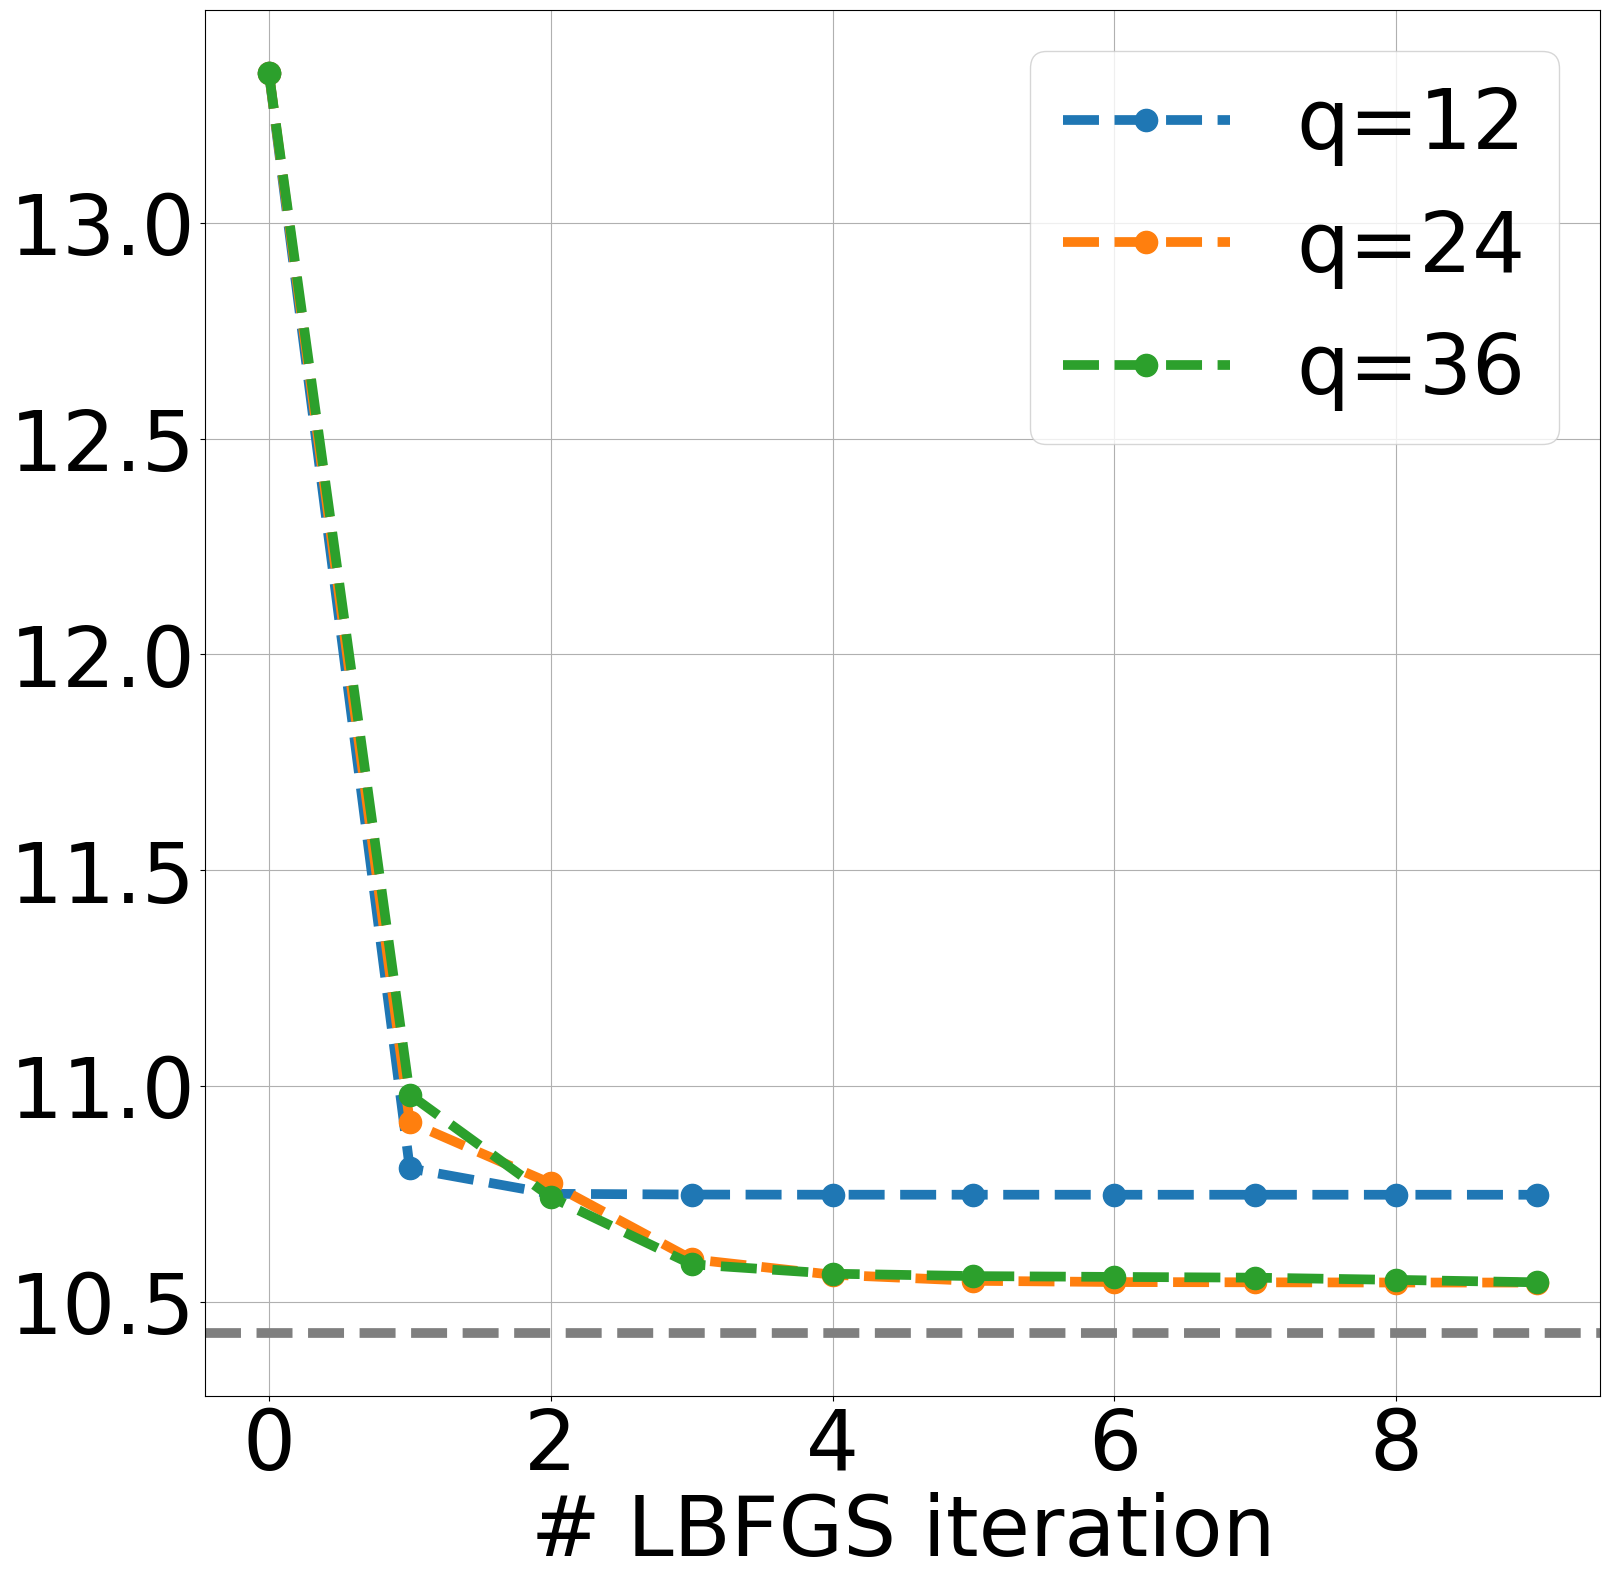

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,18))

plt.axhline(y = train_opt_loss, linestyle='--', linewidth=7, color='tab:grey')

for i in range(len(train_losses)):
    plt.plot(np.arange(len(train_losses[i]) - 5), train_losses[i][:10], '--o', linewidth=7, markersize=16, label=f'q={12 + (i)*12}')
# Set global font size
mpl.rcParams['font.size'] = 60

font_size = 60

# plt.ylim(2.5, 3)

plt.xlabel(f'# LBFGS iteration', fontsize=font_size)
# plt.ylabel(f"$\\theta_i^*(\\lambda_2)$", fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)

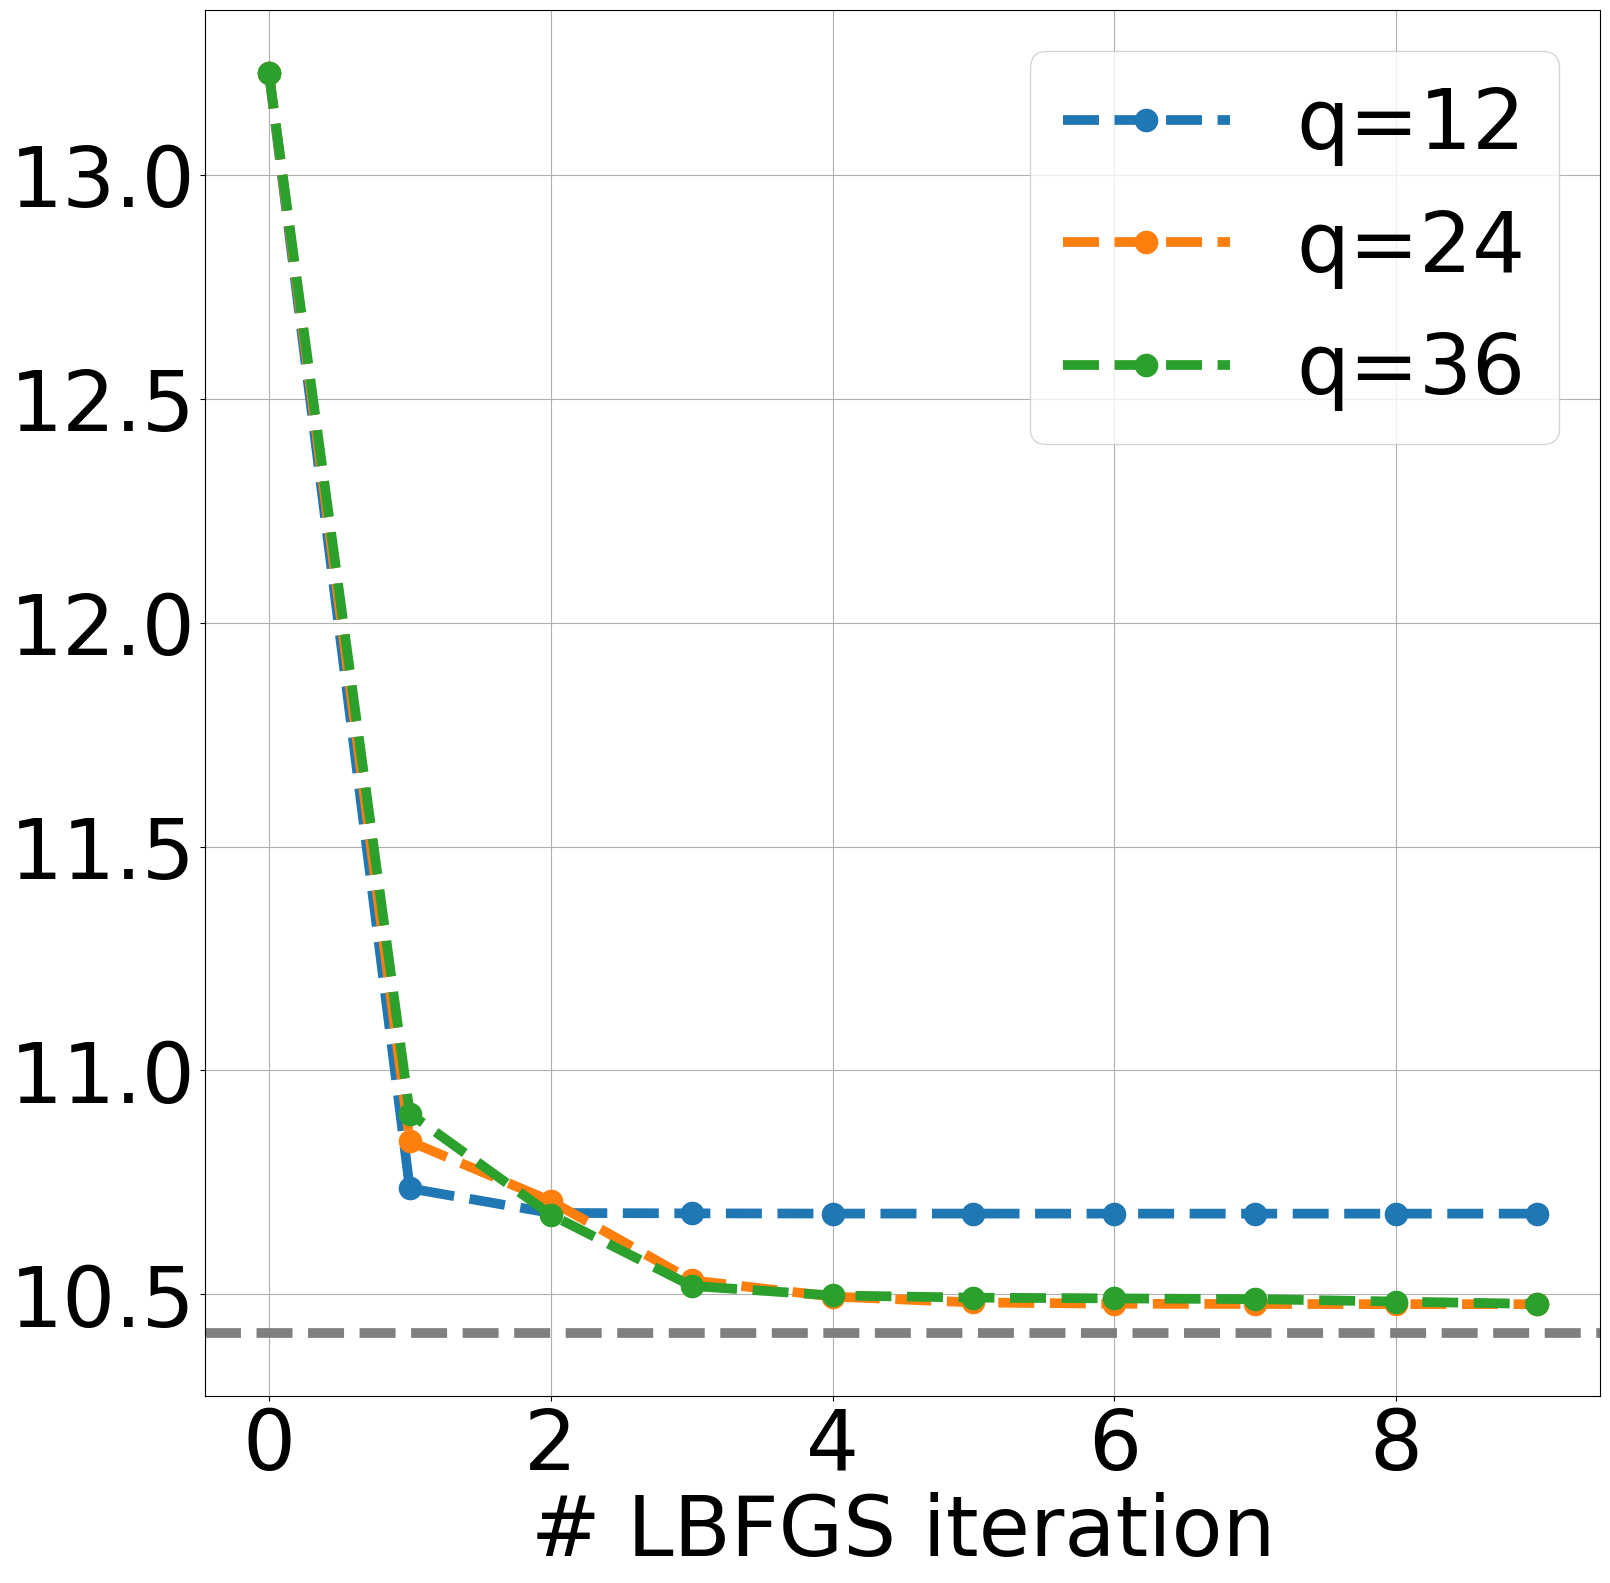

In [ ]:
# plot result of our method:
plt.figure(figsize=(18,18))

plt.axhline(y = val_opt_loss, linestyle='--', linewidth=7, color='tab:grey')

for i in range(len(val_losses)):
    plt.plot(np.arange(len(train_losses[i])- 5), val_losses[i][:10], '--o', linewidth=7, markersize=16, label=f'q={12 + (i)*12}')
mpl.rcParams['font.size'] = 60

font_size = 60


# plt.ylim(2.5, 3)

plt.xlabel(f'# LBFGS iteration', fontsize=font_size)
# plt.ylabel(f"$\\theta_i^*(\\lambda_2)$", fontsize=font_size)
plt.legend(fontsize=font_size)
plt.grid(True)